## Семинар 1 "Полносвязные нейронные сети"

ФИО: Каспарьянц Георгий Григорьевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
%matplotlib inline

### Часть 1: Линейный слой


In [2]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size, mu=0, sigma=0.1):        
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        # input_size = (N, d)
        # output_size = (N, 1)
        self.name = 'Linear'
        self.input_size = input_size
        self.output_size = output_size
        self.mu = mu
        self.sigma = sigma
        self.w = self.sigma * np.random.randn(self.output_size, self.input_size) + self.mu
        self.b = self.sigma * np.random.randn(self.output_size) + self.mu
    
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size)
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = np.array(X)
        out = np.transpose(
            self.w.dot(
                self.X.reshape([X.shape[0], self.input_size, 1])
            ),
            (1,0,2)
        ).reshape((X.shape[0],self.output_size)) + self.b
        return np.array(out) #[N, output_size]
    
    def backward(self, dLdy):
        '''
        dLdy [N, output_size]
        '''
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdw = np.sum(dLdy.reshape(dLdy.shape[0], -1, 1) * self.X.reshape(self.X.shape[0], 1, -1), axis=0)
        self.dLdb = np.sum(dLdy, axis=0)
        dLdx = []
        for i in range(dLdy.shape[0]):
            dLdx.append(np.matmul(dLdy[i].reshape(1, -1), self.w).reshape(-1))
        dLdx = np.array(dLdx)
        dLdx1 = dLdy.reshape(dLdy.shape[0], 1, -1).dot(self.w).reshape(dLdy.shape[0],-1)
        return np.array(dLdx)
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        #### YOUR CODE HERE
        assert(self.w.shape == self.dLdw.shape)
        
        self.w = self.w - learning_rate * self.dLdw
        
        

In [3]:
lm1 = Linear(2,3)
lm2 = Linear(3,10000)
lm2.forward(lm1.forward(np.random.randn(2,2)))
lm1.backward(lm2.backward(np.random.randn(2,10000)))

array([[ 0.31868997, -0.38348347],
       [-1.44154176, -0.49680055]])

### Часть 2: Сигмоида

In [4]:
class Sigmoid:
    def __init__(self):
        self.name = 'Sigmoid'
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        self.X = np.array(X)
        self.sig = 1 / (1 + np.exp(-X))
        return self.sig
        
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        #return np.array([dLdy[i] * self.sig[i] * (1 - self.sig[i]) for i in range(dLdy.shape[0])])
        return dLdy * self.sig * (1 - self.sig)
    def step(self, learning_rate):
        pass

In [5]:
lm1 = Linear(2,3)
lm2 = Linear(3,10)
s = Sigmoid()
lm2.forward(s.forward(lm1.forward(np.random.randn(2,2))))
lm1.backward(s.backward(lm2.backward(np.random.randn(2,10))))

array([[ 0.0119831 ,  0.01438626],
       [ 0.00186078,  0.00057778]])

### Часть 3: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [6]:
def softmax(X):
    a = np.exp(X)
    a /= np.sum(a, axis=1).reshape((-1,1))
    return a

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        self.name = 'NLLLoss'
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        y is np.array of size (N,), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = np.array(X)
        self.y = np.array(y)
        a = softmax(self.X)
        self.a = np.array(a)
        l = np.log(a)
        return -np.trace(l[:,y])
        #return -np.sum([l[j, y[j]] for j in range(self.X.shape[0])])
        
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        N = self.X.shape[0]
        d = self.X.shape[1]
        p = self.a
        y = self.y
        
        dpdx = (np.diag(np.ones(p.shape[1])) - p.reshape((p.shape[0], 1, -1))) * p.reshape((p.shape[0], -1, 1))
        dLdx = []
        for i in range(N):
            dLdx.append([-dpdx[i, y[i], j0] / p[i, y[i]] for j0 in range(d)])
        return np.array(dLdx)
        

In [7]:
loss = NLLLoss()
loss.forward([[1,2], [2,3]], [0,1])
loss.backward()

array([[-0.73105858,  0.73105858],
       [ 0.26894142, -0.26894142]])

### Часть 4, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [8]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.name = 'network'
        self.net = []
        for m in modules:
            self.net.append(m)
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        prev = np.array(X)
        for i in range(len(self.net)):
            prev = self.net[i].forward(prev)
        return prev
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        prev = dLdy
        for i in range(len(self.net)):
            prev = self.net[len(self.net) - i - 1].backward(prev)
        return prev
    
    def step(self, learning_rate):
        for l in self.net:
            l.step(learning_rate)
            

In [9]:
nn = NeuralNetwork([Linear(1,3), Sigmoid(), Linear(3,2), Sigmoid()])
nn.forward(np.random.randn(10,1))
nn.backward(np.random.randn(10,2))

array([[ -2.71986642e-04],
       [  1.78899395e-03],
       [  4.31584312e-04],
       [  7.09253133e-05],
       [  2.03398224e-03],
       [ -4.75630089e-04],
       [  8.42104825e-04],
       [  1.29659773e-03],
       [ -1.20588192e-03],
       [ -1.73686612e-03]])

### Часть 5, обучение на простых данных

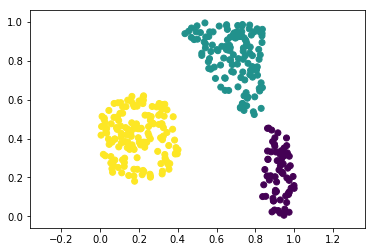

In [10]:
import matplotlib.pyplot as plt
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

In [11]:
lr = 0.01
nn = NeuralNetwork([Linear(2,10), Sigmoid(), Linear(10,10), Sigmoid(), Linear(10,3)])
loss = NLLLoss()
losts = []
for i in tqdm.tqdm(range(1000)):
    newy = nn.forward(X)
    losts.append(loss.forward(newy, y))
    nn.backward(loss.backward())
    nn.step(lr)

100%|██████████| 1000/1000 [00:17<00:00, 57.69it/s]


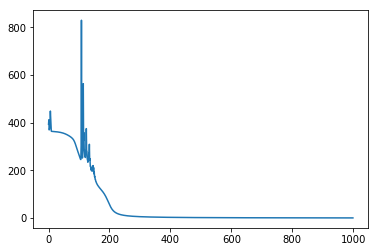

In [23]:
losts = np.array(losts)
plt.plot(losts)
plt.show()

In [24]:
def get_grid(X):
    s1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
    s2 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 100)
    return np.meshgrid(s1, s1)

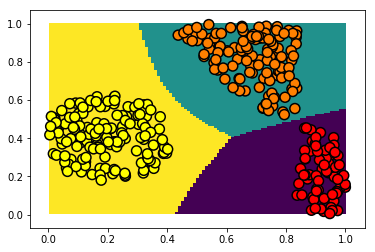

In [25]:
xc, yc = get_grid(X)

newy = np.int8(np.argmax(softmax(nn.forward(np.c_[xc.ravel(), yc.ravel()])), axis=1).reshape(xc.shape))
plt.pcolormesh(xc,yc,newy)

plt.scatter(X[:, 0], X[:, 1], c=y,cmap='autumn',s=100,edgecolors='black',linewidths=1.5)
plt.show()